In [9]:
"""
Comprehensive Model Analysis Toolkit
===================================

This automatically detects model type and applies appropriate analysis.
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, spearmanr
import pandas as pd
from typing import Dict, List, Tuple, Optional, Union, Literal
from collections import defaultdict

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

#############################################################################
#  MODEL CLASSES
#############################################################################

!git clone https://github.com/manisetayesh/predictive-feedback.git

import sys
sys.path.append('predictive-feedback')

from models.mlp import MultiLayerPerceptron
from models.hybrid import HybridMLP
from models.hebbian import HebbianMultiLayerPerceptron
from models.feedback import FAPerceptron, WMPerceptron

#############################################################################

class UniversalModelAnalyzer:
    """Universal analyzer that works with any of your model types."""

    def __init__(self, model, model_name=None):
        """
        Args:
            model: Any of your model types
            model_name: Optional name for the model (will auto-detect if None)
        """
        self.model = model
        self.model.eval()
        self.model_type = self._detect_model_type()
        self.model_name = model_name or f"{self.model_type}_{id(model)}"

        print(f"Initialized analyzer for {self.model_type}: {self.model_name}")

    def _detect_model_type(self):
        """Automatically detect the model type."""
        class_name = self.model.__class__.__name__

        if "Hybrid" in class_name:
            return "HybridMLP"
        elif "Hebbian" in class_name:
            return "HebbianMLP"
        elif "FA" in class_name or "FeedbackAlignment" in class_name:
            return "FAPerceptron"
        elif "WM" in class_name or "WeightMirror" in class_name:
            return "WMPerceptron"
        elif "MultiLayerPerceptron" in class_name or "MLP" in class_name:
            return "StandardMLP"
        else:
            return "UnknownModel"

    def _get_model_activations(self, X):
        """Get activations based on model type."""
        activations = {}

        if self.model_type == "HybridMLP":
            # Hybrid models return multiple outputs
            combined_output, m1_output, m2_output = self.model(X)

            # Get individual model activations if they have the method
            if hasattr(self.model.m1, 'forward_with_activations'):
                m1_acts = self.model.m1.forward_with_activations(X)
                for key, val in m1_acts.items():
                    activations[f'm1_{key}'] = val.detach()

            if hasattr(self.model.m2, 'forward_with_activations'):
                m2_acts = self.model.m2.forward_with_activations(X)
                for key, val in m2_acts.items():
                    activations[f'm2_{key}'] = val.detach()

            activations['combined_output'] = combined_output.detach()
            activations['m1_final'] = m1_output.detach()
            activations['m2_final'] = m2_output.detach()

        else:
            # Standard models - manually extract activations
            X_flat = X.reshape(-1, self.model.num_inputs)

            # First layer
            if hasattr(self.model, 'lin1'):
                lin1_pre = self.model.lin1(X_flat)
                activations['lin1_pre_activation'] = lin1_pre.detach()

                if hasattr(self.model, 'activation'):
                    lin1_post = self.model.activation(lin1_pre)
                    activations['lin1_post_activation'] = lin1_post.detach()
                else:
                    activations['lin1_post_activation'] = lin1_pre.detach()

            # Second layer
            if hasattr(self.model, 'lin2') and 'lin1_post_activation' in activations:
                lin2_pre = self.model.lin2(activations['lin1_post_activation'])
                activations['lin2_pre_activation'] = lin2_pre.detach()

                if hasattr(self.model, 'softmax'):
                    final_output = self.model.softmax(lin2_pre)
                    activations['final_output'] = final_output.detach()
                else:
                    activations['final_output'] = lin2_pre.detach()

            # For feedback alignment models, also extract feedback weights if available
            if self.model_type in ["FAPerceptron", "WMPerceptron"]:
                if hasattr(self.model.lin1, 'weight_fa'):
                    activations['lin1_weight_fa'] = self.model.lin1.weight_fa.detach()
                if hasattr(self.model.lin2, 'weight_fa'):
                    activations['lin2_weight_fa'] = self.model.lin2.weight_fa.detach()

        return activations

    def extract_all_activations(self, data_loader, max_batches=None):
        """Extract activations from all accessible layers."""
        all_activations = defaultdict(list)
        all_labels = []

        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(data_loader):
                if max_batches and batch_idx >= max_batches:
                    break

                batch_activations = self._get_model_activations(data)

                # Store activations (skip weight tensors)
                for name, activation in batch_activations.items():
                    if 'weight' not in name and activation.dim() > 1:  # Skip 1D weight tensors
                        all_activations[name].append(activation.cpu().numpy())

                all_labels.append(labels.cpu().numpy())

        # Concatenate all batches
        final_activations = {}
        for name, activation_list in all_activations.items():
            if activation_list:  # Only process non-empty lists
                final_activations[name] = np.concatenate(activation_list, axis=0)

        all_labels = np.concatenate(all_labels, axis=0)
        return final_activations, all_labels

    def compute_rdm(self, activations, distance_metric='correlation'):
        """Compute Representational Dissimilarity Matrix."""
        if activations.size == 0 or activations.shape[0] < 2:
            return np.array([[0]])

        if distance_metric == 'correlation':
            try:
                corr_matrix = np.corrcoef(activations)
                corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)
                rdm = 1 - corr_matrix
            except:
                rdm = np.zeros((activations.shape[0], activations.shape[0]))
        elif distance_metric == 'euclidean':
            rdm = squareform(pdist(activations, metric='euclidean'))
        elif distance_metric == 'cosine':
            rdm = squareform(pdist(activations, metric='cosine'))
        else:
            raise ValueError(f"Unknown distance metric: {distance_metric}")

        return rdm

    def perform_pca(self, activations, n_components=None):
        """Perform PCA analysis."""
        if activations.size == 0 or activations.shape[0] < 2:
            return {'n_components': 0, 'explained_variance_ratio': np.array([]), 'cumulative_variance': np.array([])}

        if n_components is None:
            n_components = min(50, activations.shape[1], activations.shape[0] - 1)

        if n_components <= 0:
            return {'n_components': 0, 'explained_variance_ratio': np.array([]), 'cumulative_variance': np.array([])}

        try:
            pca = PCA(n_components=n_components)
            transformed = pca.fit_transform(activations)

            return {
                'pca': pca,
                'transformed': transformed,
                'explained_variance_ratio': pca.explained_variance_ratio_,
                'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
                'components': pca.components_,
                'n_components': pca.n_components_
            }
        except:
            return {'n_components': 0, 'explained_variance_ratio': np.array([]), 'cumulative_variance': np.array([])}

    def analyze_model(self, data_loader, max_batches=5):
        """Comprehensive analysis of the model."""
        print(f"\n{'='*60}")
        print(f"ANALYZING {self.model_type}: {self.model_name}")
        print(f"{'='*60}")

        # Extract activations
        activations_dict, labels = self.extract_all_activations(data_loader, max_batches)

        if not activations_dict:
            print("No activations extracted!")
            return {}, labels

        results = {}

        # Analyze each layer
        for layer_name, activations in activations_dict.items():
            print(f"\nAnalyzing {layer_name}: {activations.shape}")

            # Basic statistics
            mean_act = np.mean(activations)
            std_act = np.std(activations)
            sparsity = np.mean(activations == 0) if activations.size > 0 else 0

            # RDM and PCA analysis
            rdm = self.compute_rdm(activations)
            pca_results = self.perform_pca(activations)

            results[layer_name] = {
                'activations': activations,
                'rdm': rdm,
                'pca': pca_results,
                'stats': {
                    'mean': mean_act,
                    'std': std_act,
                    'sparsity': sparsity,
                    'shape': activations.shape
                }
            }

            print(f"  Mean: {mean_act:.4f}, Std: {std_act:.4f}, Sparsity: {sparsity:.1%}")
            if pca_results['n_components'] > 0:
                print(f"  PC1: {pca_results['explained_variance_ratio'][0]:.1%} variance")

        return results, labels

    def plot_layer_analysis(self, results, labels, layer_name):
        """Plot comprehensive analysis for a specific layer."""
        if layer_name not in results:
            print(f"Layer {layer_name} not found in results!")
            return

        layer_results = results[layer_name]
        n_samples = layer_results['activations'].shape[0]
        sample_labels = labels[:n_samples]

        # Create subplot layout
        fig = plt.figure(figsize=(15, 10))

        # RDM plot
        ax1 = plt.subplot(2, 3, 1)
        sns.heatmap(layer_results['rdm'], annot=False, cmap='viridis', square=True, ax=ax1)
        ax1.set_title(f'RDM: {layer_name}')

        # PCA variance plot
        ax2 = plt.subplot(2, 3, 2)
        if layer_results['pca']['n_components'] > 0:
            n_show = min(15, len(layer_results['pca']['explained_variance_ratio']))
            ax2.bar(range(1, n_show + 1), layer_results['pca']['explained_variance_ratio'][:n_show])
            ax2.set_xlabel('Principal Component')
            ax2.set_ylabel('Explained Variance Ratio')
            ax2.set_title(f'PCA Variance: {layer_name}')

        # PCA 2D plot
        ax3 = plt.subplot(2, 3, 3)
        if layer_results['pca']['n_components'] >= 2:
            scatter = ax3.scatter(
                layer_results['pca']['transformed'][:, 0],
                layer_results['pca']['transformed'][:, 1],
                c=sample_labels, cmap='tab10', alpha=0.7, s=30
            )
            ax3.set_xlabel(f'PC1 ({layer_results["pca"]["explained_variance_ratio"][0]:.1%})')
            ax3.set_ylabel(f'PC2 ({layer_results["pca"]["explained_variance_ratio"][1]:.1%})')
            ax3.set_title(f'PCA 2D: {layer_name}')
            plt.colorbar(scatter, ax=ax3)

        # Activation distribution
        ax4 = plt.subplot(2, 3, 4)
        flat_activations = layer_results['activations'].flatten()
        ax4.hist(flat_activations[np.isfinite(flat_activations)], bins=50, alpha=0.7)
        ax4.set_xlabel('Activation Value')
        ax4.set_ylabel('Frequency')
        ax4.set_title(f'Activation Distribution: {layer_name}')

        # Cumulative PCA variance
        ax5 = plt.subplot(2, 3, 5)
        if layer_results['pca']['n_components'] > 0:
            n_show = min(15, len(layer_results['pca']['cumulative_variance']))
            ax5.plot(range(1, n_show + 1), layer_results['pca']['cumulative_variance'][:n_show], 'bo-')
            ax5.set_xlabel('Principal Component')
            ax5.set_ylabel('Cumulative Explained Variance')
            ax5.set_title(f'Cumulative PCA: {layer_name}')
            ax5.grid(True, alpha=0.3)

        # Statistics summary
        ax6 = plt.subplot(2, 3, 6)
        stats = layer_results['stats']
        ax6.text(0.1, 0.8, f"Shape: {stats['shape']}", transform=ax6.transAxes, fontsize=12)
        ax6.text(0.1, 0.6, f"Mean: {stats['mean']:.4f}", transform=ax6.transAxes, fontsize=12)
        ax6.text(0.1, 0.4, f"Std: {stats['std']:.4f}", transform=ax6.transAxes, fontsize=12)
        ax6.text(0.1, 0.2, f"Sparsity: {stats['sparsity']:.1%}", transform=ax6.transAxes, fontsize=12)
        ax6.set_title(f'Statistics: {layer_name}')
        ax6.axis('off')

        plt.tight_layout()
        plt.show()


class MultiModelComparator:
    """Compare multiple models of different types."""

    def __init__(self):
        self.analyzers = {}
        self.results = {}

    def add_model(self, model, name, data_loader, max_batches=5):
        """Add a model to the comparison."""
        analyzer = UniversalModelAnalyzer(model, name)
        results, labels = analyzer.analyze_model(data_loader, max_batches)

        self.analyzers[name] = analyzer
        self.results[name] = {'results': results, 'labels': labels}

        print(f"Added {name} to comparison")

    def compare_models(self, layer_mapping=None):
        """Compare representations across models."""
        if len(self.results) < 2:
            print("Need at least 2 models to compare!")
            return

        # Default layer mapping if none provided
        if layer_mapping is None:
            layer_mapping = {
                'final_output': ['final_output', 'combined_output', 'm1_final', 'm2_final'],
                'hidden_layer': ['lin1_post_activation', 'm1_lin1_post_activation', 'm2_lin1_post_activation']
            }

        comparison_results = {}

        for layer_type, layer_names in layer_mapping.items():
            print(f"\nComparing {layer_type}:")

            # Find models that have this layer type
            available_models = {}
            for model_name, model_data in self.results.items():
                for layer_name in layer_names:
                    if layer_name in model_data['results']:
                        available_models[model_name] = layer_name
                        break

            if len(available_models) < 2:
                print(f"  Not enough models have {layer_type} layers")
                continue

            # Compare all pairs
            model_names = list(available_models.keys())
            for i in range(len(model_names)):
                for j in range(i+1, len(model_names)):
                    model1_name, model2_name = model_names[i], model_names[j]
                    layer1_name = available_models[model1_name]
                    layer2_name = available_models[model2_name]

                    # Get RDMs
                    rdm1 = self.results[model1_name]['results'][layer1_name]['rdm']
                    rdm2 = self.results[model2_name]['results'][layer2_name]['rdm']

                    # Compare RDMs
                    min_size = min(rdm1.shape[0], rdm2.shape[0])
                    if min_size > 1:
                        rdm1_small = rdm1[:min_size, :min_size]
                        rdm2_small = rdm2[:min_size, :min_size]

                        mask = np.triu(np.ones_like(rdm1_small, dtype=bool), k=1)
                        if mask.sum() > 0:
                            corr, p_val = pearsonr(rdm1_small[mask], rdm2_small[mask])

                            comparison_key = f"{model1_name}_vs_{model2_name}_{layer_type}"
                            comparison_results[comparison_key] = {
                                'rdm_correlation': corr,
                                'p_value': p_val,
                                'layer1': f"{model1_name}.{layer1_name}",
                                'layer2': f"{model2_name}.{layer2_name}"
                            }

                            print(f"  {model1_name} vs {model2_name}: RDM corr = {corr:.3f} (p={p_val:.3e})")

        return comparison_results

    def plot_model_comparison(self, comparison_results):
        """Plot comparison results across models."""
        if not comparison_results:
            print("No comparison results to plot!")
            return

        # Extract data for plotting
        comparisons = []
        correlations = []

        for comp_name, comp_data in comparison_results.items():
            comparisons.append(comp_name.replace('_vs_', '\nvs\n'))
            correlations.append(comp_data['rdm_correlation'])

        # Create plot
        plt.figure(figsize=(12, 8))
        bars = plt.bar(range(len(comparisons)), correlations, alpha=0.7)

        # Color bars based on correlation strength
        for bar, corr in zip(bars, correlations):
            if corr > 0.7:
                bar.set_color('green')
            elif corr > 0.3:
                bar.set_color('orange')
            else:
                bar.set_color('red')

        plt.xlabel('Model Comparisons')
        plt.ylabel('RDM Correlation')
        plt.title('Cross-Model Representational Similarity')
        plt.xticks(range(len(comparisons)), comparisons, rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def generate_report(self, comparison_results=None):
        """Generate a comprehensive analysis report."""
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL ANALYSIS REPORT")
        print("="*80)

        # Model summary
        print(f"\nAnalyzed {len(self.results)} models:")
        for name, data in self.results.items():
            analyzer = self.analyzers[name]
            num_layers = len(data['results'])
            print(f"  {name} ({analyzer.model_type}): {num_layers} layers analyzed")

        # Individual model summaries
        for name, data in self.results.items():
            print(f"\n{name.upper()} SUMMARY:")
            print("-" * 40)

            for layer_name, layer_results in data['results'].items():
                stats = layer_results['stats']
                pca = layer_results['pca']

                print(f"  {layer_name}:")
                print(f"    Shape: {stats['shape']}")
                print(f"    Mean activation: {stats['mean']:.4f}")
                print(f"    Sparsity: {stats['sparsity']:.1%}")
                if pca['n_components'] > 0:
                    print(f"    PC1 variance: {pca['explained_variance_ratio'][0]:.1%}")

        # Comparison summary
        if comparison_results:
            print(f"\nCROSS-MODEL COMPARISONS:")
            print("-" * 40)

            for comp_name, comp_data in comparison_results.items():
                print(f"  {comp_name}: {comp_data['rdm_correlation']:.3f}")

        print(f"\n{'='*80}")


#############################################################################

def create_sample_data(num_samples=400, input_size=784, num_classes=10, batch_size=32):
    """Create structured sample data for testing."""
    X = []
    y = []

    for class_idx in range(num_classes):
        samples_per_class = num_samples // num_classes
        class_mean = torch.randn(input_size) * 0.3 + class_idx * 0.1
        class_data = torch.randn(samples_per_class, input_size) * 0.2 + class_mean

        X.append(class_data)
        y.extend([class_idx] * samples_per_class)

    X = torch.cat(X, dim=0)
    y = torch.tensor(y)

    # Shuffle
    perm = torch.randperm(len(X))
    X, y = X[perm], y[perm]

    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return dataloader


#############################################################################

def analyze_single_model(model, model_name, data_loader=None, max_batches=5):
    """Analyze a single model."""
    if data_loader is None:
        data_loader = create_sample_data(num_samples=200, batch_size=32)

    analyzer = UniversalModelAnalyzer(model, model_name)
    results, labels = analyzer.analyze_model(data_loader, max_batches)

    # Plot key layers
    key_layers = ['final_output', 'combined_output', 'lin1_post_activation']
    for layer_name in key_layers:
        if layer_name in results:
            analyzer.plot_layer_analysis(results, labels, layer_name)
            break  # Just plot the first available key layer

    return analyzer, results, labels


def compare_all_models(models_dict, data_loader=None, max_batches=3):
    """Compare multiple models of different types."""
    if data_loader is None:
        data_loader = create_sample_data(num_samples=200, batch_size=32)

    comparator = MultiModelComparator()

    # Add all models
    for name, model in models_dict.items():
        comparator.add_model(model, name, data_loader, max_batches)

    # Compare models
    comparison_results = comparator.compare_models()

    # Plot comparison
    comparator.plot_model_comparison(comparison_results)

    # Generate report
    comparator.generate_report(comparison_results)

    return comparator, comparison_results


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("COMPREHENSIVE MODEL ANALYSIS ")
print("=" * 60)
print("\nMain functions:")
print("• analyze_single_model(model, name) - Analyze one model")
print("• compare_all_models(models_dict) - Compare multiple models")
print("\nExample usage:")
print("analyzer, results, labels = analyze_single_model(my_model, 'MyModel')")
print("comparator, comparisons = compare_all_models({'Model1': model1, 'Model2': model2})")

fatal: destination path 'predictive-feedback' already exists and is not an empty directory.
COMPREHENSIVE MODEL ANALYSIS 

Main functions:
• analyze_single_model(model, name) - Analyze one model
• compare_all_models(models_dict) - Compare multiple models

Example usage:
analyzer, results, labels = analyze_single_model(my_model, 'MyModel')
comparator, comparisons = compare_all_models({'Model1': model1, 'Model2': model2})


In [10]:
#Set random seeds
torch.manual_seed(42)
np.random.seed(42)

Initialized analyzer for StandardMLP: StandardMLP

ANALYZING StandardMLP: StandardMLP

Analyzing lin1_pre_activation: (160, 100)
  Mean: 0.0376, Std: 0.3728, Sparsity: 0.0%
  PC1: 46.0% variance

Analyzing lin1_post_activation: (160, 100)
  Mean: 0.1617, Std: 0.2368, Sparsity: 46.6%
  PC1: 49.9% variance

Analyzing lin2_pre_activation: (160, 10)
  Mean: -0.0007, Std: 0.1807, Sparsity: 0.0%
  PC1: 53.1% variance

Analyzing final_output: (160, 10)
  Mean: 0.1000, Std: 0.0193, Sparsity: 0.0%
  PC1: 61.4% variance


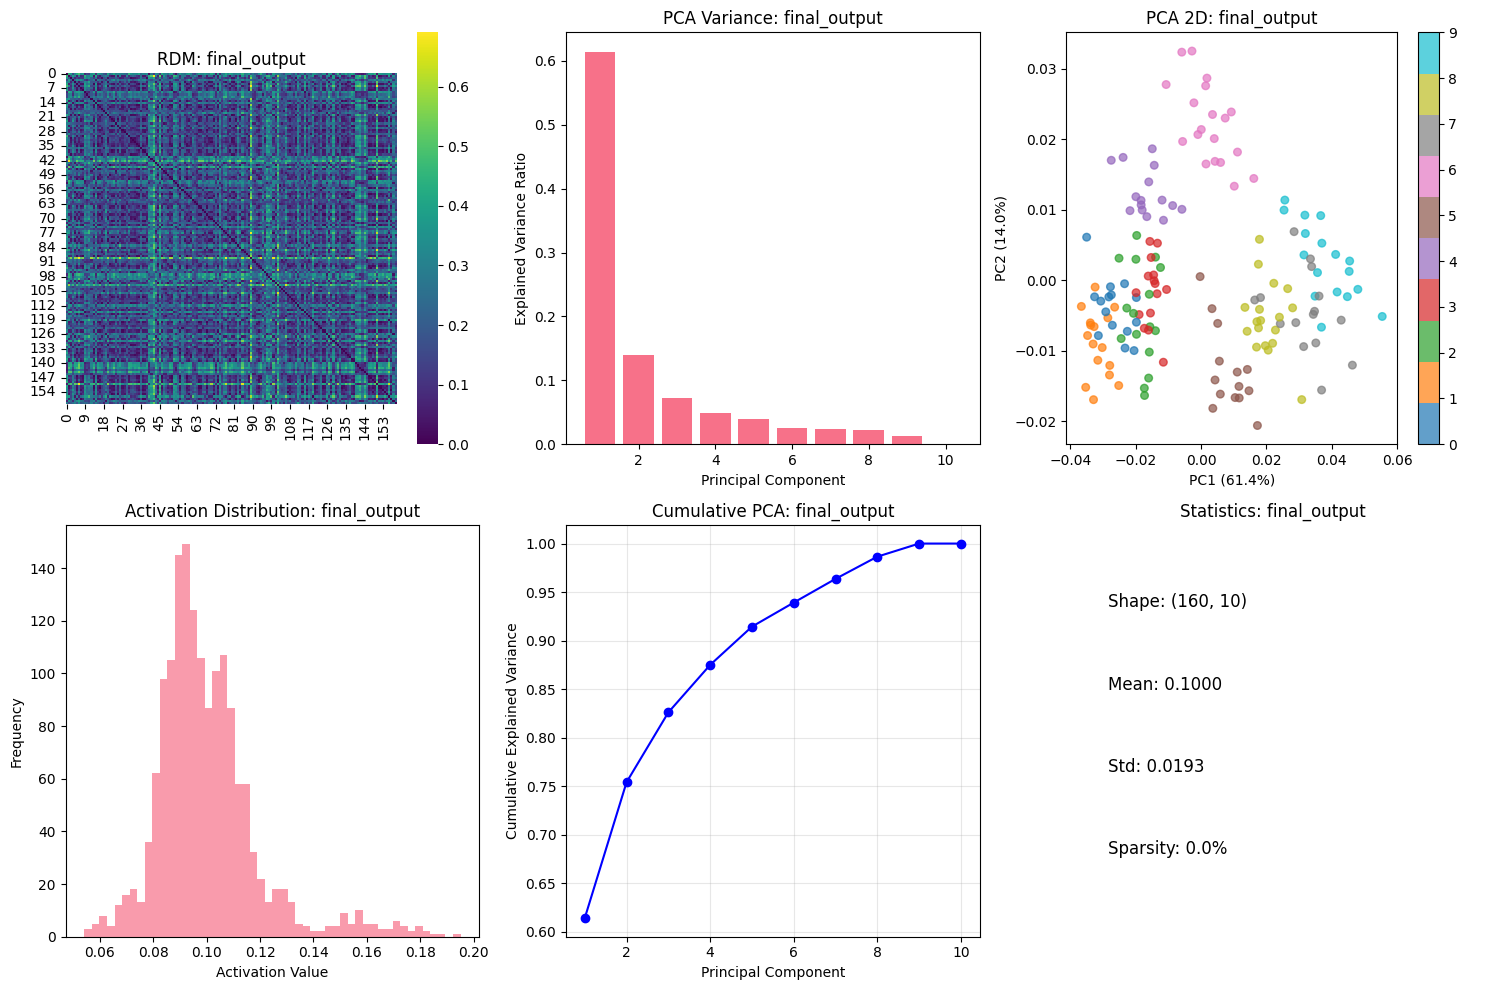

Initialized analyzer for HebbianMLP: HebbianMLP

ANALYZING HebbianMLP: HebbianMLP

Analyzing lin1_pre_activation: (160, 100)
  Mean: 0.0222, Std: 0.3650, Sparsity: 0.0%
  PC1: 44.7% variance

Analyzing lin1_post_activation: (160, 100)
  Mean: 0.5056, Std: 0.0875, Sparsity: 0.0%
  PC1: 43.3% variance

Analyzing lin2_pre_activation: (160, 10)
  Mean: -0.1484, Std: 0.2490, Sparsity: 0.0%
  PC1: 59.3% variance

Analyzing final_output: (160, 10)
  Mean: 0.1000, Std: 0.0239, Sparsity: 0.0%
  PC1: 54.3% variance


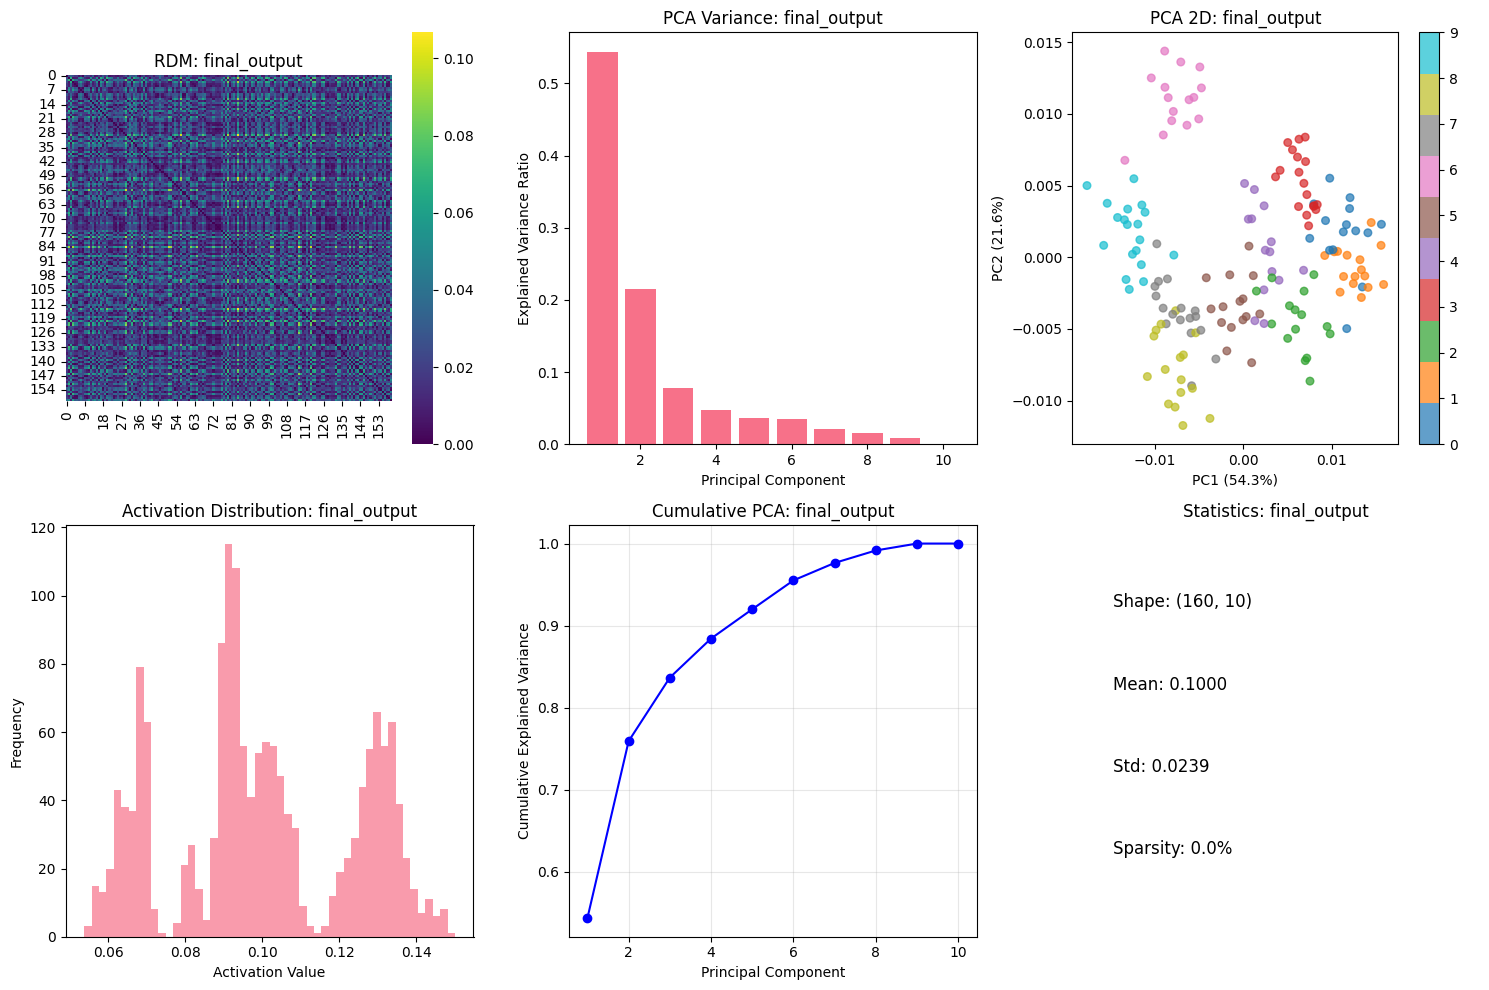

Initialized analyzer for FAPerceptron: FeedbackAlignment

ANALYZING FAPerceptron: FeedbackAlignment

Analyzing lin1_pre_activation: (160, 100)
  Mean: -0.0333, Std: 0.3738, Sparsity: 0.0%
  PC1: 47.0% variance

Analyzing lin1_post_activation: (160, 100)
  Mean: 0.4918, Std: 0.0894, Sparsity: 0.0%
  PC1: 45.3% variance

Analyzing lin2_pre_activation: (160, 10)
  Mean: -0.1516, Std: 0.1584, Sparsity: 0.0%
  PC1: 43.8% variance

Analyzing final_output: (160, 10)
  Mean: 0.1000, Std: 0.0161, Sparsity: 0.0%
  PC1: 43.1% variance


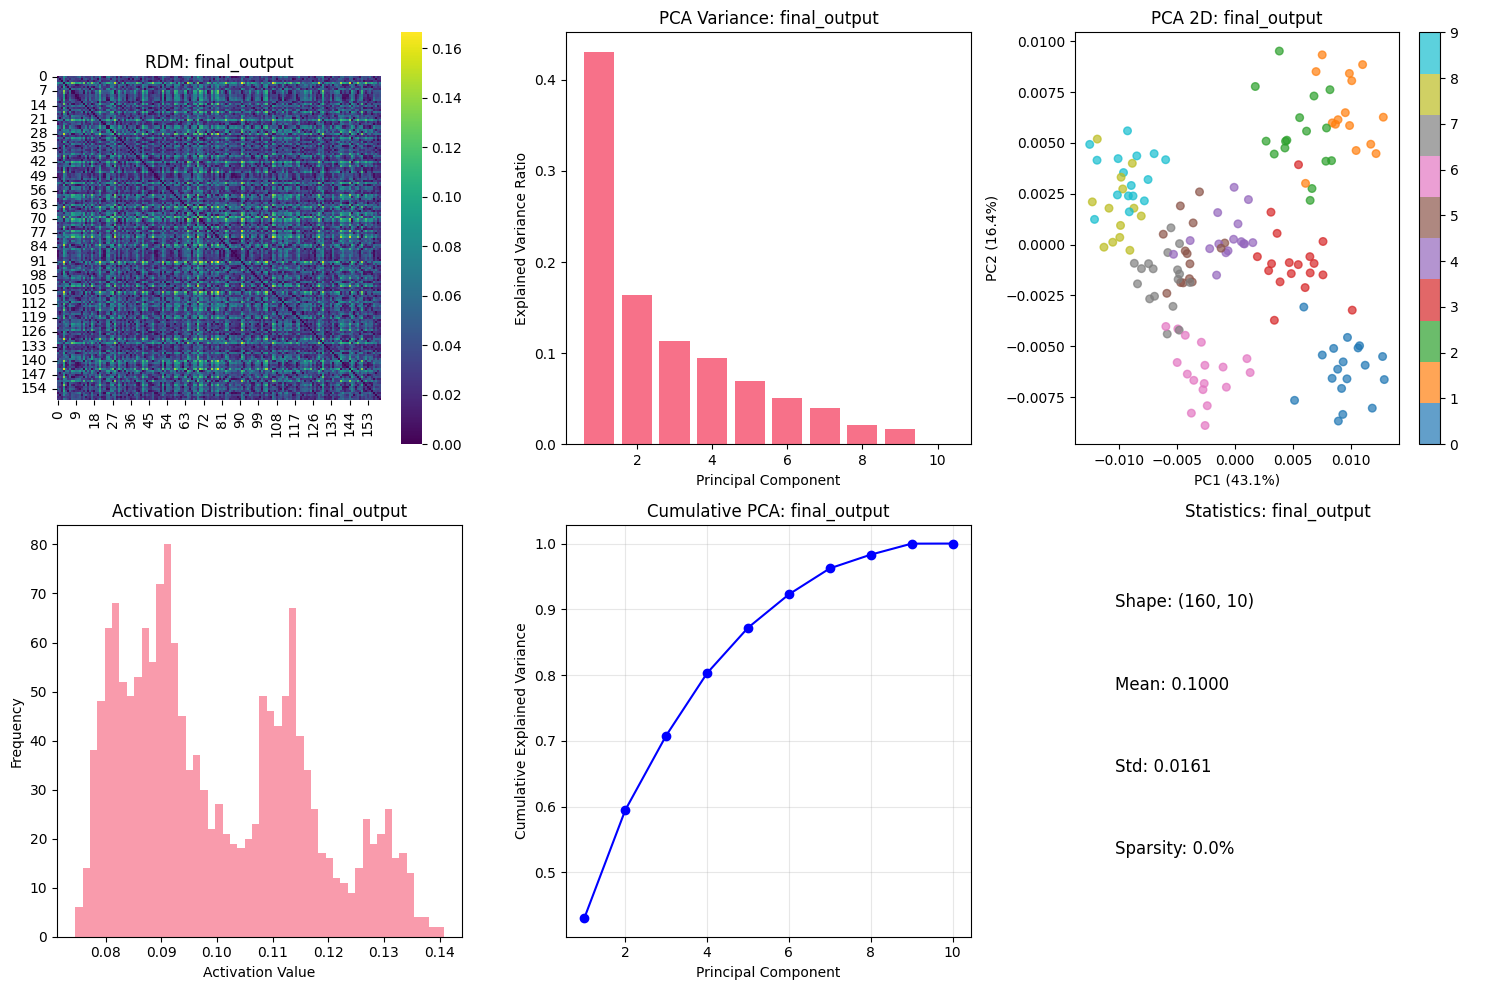

In [11]:
standard_mlp = MultiLayerPerceptron(784, 10, 100, "relu", True)
hebbian_mlp = HebbianMultiLayerPerceptron(num_inputs=784, num_outputs=10, num_hidden=100)
fa_mlp = FAPerceptron(num_inputs=784, num_outputs=10, num_hidden=100)

analyzer, results, labels = analyze_single_model(standard_mlp, "StandardMLP")
analyzer, results, labels = analyze_single_model(hebbian_mlp, "HebbianMLP")
analyzer, results, labels = analyze_single_model(fa_mlp, "FeedbackAlignment")